In [80]:
using Dates
using JuMP
using CSV
using DataFrames
using LinearAlgebra
using Pkg
using IJulia
using Distributions
using Plots


In [38]:
ENV["COLUMNS"] = 200;

In [39]:
# Assuming your Julia file is named "COVIDResourceAllocation.jl"
include("COVIDResourceAllocation.jl")
using .COVIDResourceAllocation


In [54]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
start_date = Date(2020, 3, 4)
end_date   = Date(2020, 5, 22)
T = (end_date - start_date).value + 1
travel_threshold_hours = 8.0;

In [41]:
pct_nurses_available = 0.5
patients_per_nurse_covid = 2.5
nurse_hrs_per_week_covid = 36

@show nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7
@show nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid

@show nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid;

nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7 = 5.142857142857143
nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid = 4.666666666666666
nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid = 1.8666666666666665


In [42]:
adj = adjacencies(states, level=:state, source=:google, threshold=travel_threshold_hours);

In [81]:
start_date = Date(2020, 3, 4)
end_date   = Date(2020, 5, 22)
date_range = start_date:end_date
T = (end_date - start_date).value + 1

hospitalized_days = ceil(mean(Weibull(1.38,12.88)))
forecast_initial = forecast(
    states, start_date-Dates.Day(1), start_date-Dates.Day(1),
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_active = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_admitted = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_discharged = forecast(
    states, start_date-Dates.Day(hospitalized_days), end_date-Dates.Day(ceil(mean(Weibull(1.38,12.88)))),
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
);

In [136]:
net_patients_per_day = [(
    forecast_initial[i]
	- forecast_discharged[i,t]
	+ sum(L[t-t₁+1]forecast_admitted[i,t₁] for t₁ in 1:t)
	) for i in 1:N, t in 1:T
]
demand = net_patients_per_day*nurse_days_per_patient_day_covid

11×80 Matrix{Float64}:
 0.0     0.0      0.0      0.0      0.0       0.0       0.0        0.0       0.0       0.0       6.96444  …   4681.03     4529.17     4382.4      4235.18     4089.9       3941.59      3798.15
 0.0     0.0      0.0      0.0      0.0       0.0       0.0        0.0       0.0       0.0       0.0           609.842     605.843     594.718     583.626     573.34       563.64       547.746
 0.0     0.0      0.0      0.0      3.88752   7.65738  11.231     14.4845   17.6288   20.6109   27.2442       4966.43     4831.48     4692.75     4557.62     4418.99      4287.34      4151.55
 0.0     0.0      0.0      0.0      0.0       0.0       0.0        0.0       0.0       0.0       0.0          5031.65     4982.09     4916.88     4844.3      4782.85      4710.57      4649.61
 0.0     0.0      0.0      0.0      0.0       0.0       0.0        0.0       0.0       0.0       0.0            88.3822     88.004      87.7289     87.3882     87.238       86.9813      86.9124
 0.0     0.0  

In [135]:
#demand = forecast_active * Float32(nurse_days_per_patient_day_covid);

In [118]:
nurses = n_nurses(states) * Float32(pct_nurses_available);

In [151]:
isolation_spot = vec([0,0,0,0,0,0,1,1,0,0,0])
isolation_spot2 = vec([0,0,0,0,0,0,0,0,0,0,0])

model = nurse_allocation(
    nurses,
    demand,
    adj,
    isolation_spot,
    sent_penalty=0.01,
    smoothness_penalty=0,

    no_artificial_shortage =false,
	no_worse_shortage =false,
	fully_connected=false,

    
    min_send_amt=0,
    setup_cost=0,
    
    verbose=true
)
sent = value.(model[:sent])
println("termination status: ", termination_status(model))
println("solve time: ", round(solve_time(model), digits=3), "s")
println("objective function value: ", round(objective_value(model), digits=3))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-21
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[x86] - Darwin 22.6.0 22G513)

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 12320 rows, 10560 columns and 2141040 nonzeros
Model fingerprint: 0x843c3022
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 4e+04]
Presolve removed 9680 rows and 880 columns
Presolve time: 0.86s
Presolved: 2640 rows, 9680 columns, 2130480 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.15s

Barrier performed 0 iterations in 1.35 seconds (0.69 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Tim

In [152]:
results = NurseAllocationResults.results_all(sent, nurses, demand, states, start_date);

In [153]:
println("Total sent: ", results.total_sent)
println("Total shortage: ", results.total_shortage)
println("Average load: ", results.average_load)

Total sent: 17464.75978603452
Total shortage: 1.7616597592689865e6
Average load: 1.2413078923201477


In [154]:
results.summary_table

Row,state,total_sent,total_received,initial_nurses,total_nurse_days,total_demand,total_shortage,average_load
,String,Float64,Float64,Float32,Float64,Float64,Float64,Float64
1,CT,1148.25,0.0,2296.5,91860.0,2.69254e5,2.03978e5,2.93113
2,DE,330.5,0.0,661.0,26440.0,23431.3,7735.62,0.886206
3,MA,2536.5,0.0,5073.0,202920.0,2.51741e5,1.23807e5,1.24059
4,MD,1542.25,0.0,3084.5,123380.0,2.27469e5,1.46574e5,1.84364
5,ME,490.5,0.0,981.0,39240.0,5959.4,0.0,0.151871
6,NH,483.5,0.0,967.0,38680.0,16085.1,194.812,0.41585
7,NJ,0.0,8420.37,3326.0,475291.0,8.26765e5,4.60779e5,1.86297
8,NY,6900.01,9044.39,9773.5,1.41364e6,1.62397e6,6.20395e5,1.1471
9,PA,3547.25,0.0,7094.5,2.87993e5,3.4882e5,172367.0,1.22919


In [155]:
results.sent_matrix_table

Row,state,CT,DE,MA,MD,ME,NH,NJ,NY,PA,RI,VT
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1148.25,0.0,0.0,0.0
2,DE,0.0,0.0,0.0,0.0,0.0,0.0,330.5,0.0,0.0,0.0,0.0
3,MA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2536.5,0.0,0.0,0.0
4,MD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1542.25,0.0,0.0,0.0
5,ME,0.0,0.0,0.0,0.0,0.0,0.0,490.5,0.0,0.0,0.0,0.0
6,NH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,483.5,0.0,0.0,0.0
7,NJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,NY,0.0,0.0,0.0,0.0,0.0,0.0,6900.01,0.0,0.0,0.0,0.0
9,PA,0.0,0.0,0.0,0.0,0.0,0.0,526.607,3020.64,0.0,0.0,0.0


In [156]:
df = results.complete_table
cleaned_df = DataFrame(State=df.state, Date=df.date, Shortage=df.shortage)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :State)
shortage_matrix = zeros(11, T)
for (i, state_df) in enumerate(grouped_df)
    shortage_matrix[i, :] .= state_df.Shortage
end

# check the shortage matrix
size(shortage_matrix)

(11, 80)

In [16]:
using Plots

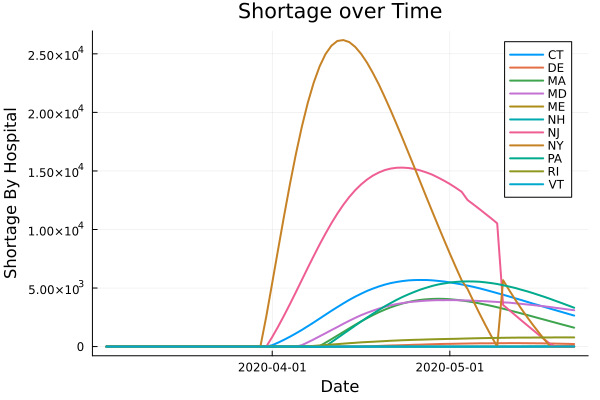

In [172]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)

net_shortage = shortage_matrix
date_range = start_date:end_date
plot(date_range, [vec(net_shortage[i,:]) for i in 1:size(net_shortage)[1]],
     xlabel = "Date",
     ylabel = "Shortage By Hospital",
     title = "Shortage over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)
#savefig(joinpath("../figures", "NAnew_shortage_plot304-522.png"))

In [178]:
state_shortage_df = DataFrame(permutedims(net_shortage), :auto)

columns = ["Column_$i" for i in 1:length(states)]
rename!(state_shortage_df, states)

describe(state_shortage_df)


# using CSV
CSV.write("../data output/DSstateNAshortage.csv",describe(state_shortage_df))



"../data output/DSstateNAshortage.csv"

In [159]:
net_shortage_p_hosp = vec(sum(net_shortage, dims=1))
net_shortage_df = DataFrame(date = date_range, shortage = net_shortage_p_hosp)
using CSV
CSV.write("../data output/NAnewShortage304-522.csv",net_shortage_df)

"../data output/NAnewShortage304-522.csv"

In [166]:
describe(net_shortage_df.shortage)

Length =  80
Mean = 22020.746991
Std_Deviation = 19881.624903
Minimum = 0.000000
first_Quartile = 0.000000
Median = 19548.494774
third_Quartile = 41742.563282
Maximum = 52192.178040

overall_df_summary = DataFrame(
    Statistic = ["Length", "Mean", "Std. Deviation", "Minimum", "1st Quartile", "Median", "3rd Quartile", "Maximum"],
    Value = [Length, mean, Std_Deviation, Minimum, first_Quartile, Median, third_Quartile, Maximum]
)

# Show DataFrame
show(overall_df_summary, allrows=true)

using CSV
CSV.write("../data output/DSOverallNAShortage.csv",overall_df_summary)



Summary Stats:
Length:         80
Missing Count:  0
Mean:           22020.746991
Std. Deviation: 19881.624903
Minimum:        0.000000
1st Quartile:   0.000000
Median:         19548.494774
3rd Quartile:   41742.563282
Maximum:        52192.178040
Type:           Float64
8×2 DataFrame
 Row │ Statistic       Value   
     │ String          Any     
─────┼─────────────────────────
   1 │ Length          80
   2 │ Mean            mean
   3 │ Std. Deviation  19881.6
   4 │ Minimum         0.0
   5 │ 1st Quartile    0.0
   6 │ Median          19548.5
   7 │ 3rd Quartile    41742.6
   8 │ Maximum         52192.2

"../data output/DSOverallNAShortage.csv"

In [161]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)

df = results.complete_table
cleaned_df = DataFrame(State=df.state, Date=df.date, Sent=df.sent)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :State)
sent_matrix = zeros(11, T)
for (i, state_df) in enumerate(grouped_df)
    sent_matrix[i, :] .= state_df.Sent
end

# check the shortage matrix
#size(shortage_matrix)

plot(date_range, [vec(sent_matrix[i,:]) for i in 1:size(sent_matrix)[1]],
     xlabel = "Date",
     ylabel = "Nurse Transfer By Hospital",
     title = "Total Nurse Transfer Over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)
savefig(joinpath("../figures", "NAnew_NSent_plot304-522.png"))

"/Users/siyunyan/Desktop/Healthcare-Resources-Optimization-main/figures/NAnew_NSent_plot304-522.png"

In [171]:
describe(net_sent_df.shortage)

Length = 80
Mean = 218.309497
Std_Deviation = 1332.476609
Minimum = 0.000000
first_Quartile = 0.000000
Median = 0.000000
third_Quartile = 0.000000
Maximum =  10038.142889

sent_df_summary = DataFrame(
    Statistic = ["Length", "Mean", "Std. Deviation", "Minimum", "1st Quartile", "Median", "3rd Quartile", "Maximum"],
    Value = [Length, mean, Std_Deviation, Minimum, first_Quartile, Median, third_Quartile, Maximum]
)

# # Show DataFrame
# show(overall_df_summary, allrows=true)

# using CSV
CSV.write("../data output/DSNASent.csv",state_df_summary)



Summary Stats:
Length:         80
Missing Count:  0
Mean:           218.309497
Std. Deviation: 1332.476609
Minimum:        0.000000
1st Quartile:   0.000000
Median:         0.000000
3rd Quartile:   0.000000
Maximum:        10038.142889
Type:           Float64


"../data output/DSNASent.csv"

In [162]:
net_sentn_hosp = vec(sum(sent_matrix, dims=1))
net_sent_df = DataFrame(date = date_range, shortage = net_sentn_hosp)
using CSV
CSV.write("../data output/NAnewSent304-522.csv",net_sent_df)

"../data output/NAnewSent304-522.csv"

In [150]:
results.sent_to

Dict{String, Vector{String}} with 11 entries:
  "RI" => ["NJ"]
  "NY" => ["DE", "MA", "MD", "NJ", "PA"]
  "ME" => ["NJ"]
  "NJ" => []
  "DE" => ["NY"]
  "MD" => ["NY"]
  "NH" => ["NJ"]
  "CT" => ["NY"]
  "MA" => ["NY"]
  "PA" => ["NJ", "NY"]
  "VT" => ["NJ"]